New York City Airbnb Open Data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

!wget $data -O data-homework.csv


--2021-09-26 22:49:14--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: 'data-homework.csv'

     0K .......... .......... .......... .......... ..........  0%  628K 11s
    50K .......... .......... .......... .......... ..........  1% 1.64M 7s
   100K .......... .......... .......... .......... ..........  2% 1.01M 7s
   150K .......... .......... .......... .......... ..........  2% 3.05M 6s
   200K .......... .......... .......... .......... ..........  3% 3.79M 5s
   250K .......... .......... .......... .......... ..........  4% 1.15M 5s
   300K .......... .......... .......... .......... ..........  5% 5.59M 4s
   350K .......... ..

<H2> DATA PREPARATION</H2>

In [46]:
df = pd.read_csv('data-homework.csv')

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [47]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [48]:
categorical = [
'neighbourhood_group',
'room_type',
]

numerical=['latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']

 

Filling the missing values with 0.


### Make price binary

* We need to turn the price variable from numeric into binary.
* Let's create a variable `above_average` which is `1` if the price is above (or equal to) `152`.


In [49]:
def prepare_df(df):
    df_copy = df[categorical+numerical]
    df_copy = df_copy.fillna(0)
    df_copy.price = (df_copy.price >= 152).astype(int)
    return df_copy

In [50]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [51]:
df_copy = prepare_df(df)


In [52]:
df_copy.isnull().sum()

neighbourhood_group               0
room_type                         0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

<b>Question 1</b> <br>
What is the most frequent observation (mode) for the column 'neighbourhood_group'?



In [53]:
display(df_copy.mode()['neighbourhood_group'][0]);


'Manhattan'


### Split the data

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to 42.
* Make sure that the target value ('price') is not in your dataframe.

In [54]:
len(df_copy)

48895

In [55]:
from sklearn.model_selection import train_test_split

df_full_train , df_test =train_test_split(df_copy,test_size=0.2,random_state=42) # Using 20% test Size seed 42

# df_full_train = 80% of df_copy
# df_test = 20% of df_copy

In [56]:
len(df_full_train),len(df_test)

(39116, 9779)

In [57]:
df_train , df_val = train_test_split(df_full_train,test_size=0.25,random_state=42) # From full train split 

In [58]:
len(df_train) , len(df_val) , len (df_test) 

# validation data set of full train 
# df_full_train = 80% of df_copy
# df_test = 20% of df_copy
# df_val = 20% of df_copy and 25% of df_full_train



(29337, 9779, 9779)

In [59]:
df_train= df_train.reset_index(drop=True) # not necessary for models to work
df_val = df_val.reset_index(drop=True) # not necessary for models to work
df_test = df_test.reset_index(drop=True) # not necessary for models to work
df_full_train = df_full_train.reset_index(drop=True)

In [60]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [61]:
del df_train['price']
del df_val['price']
del df_test['price']

In [62]:
y_train

array([0, 0, 0, ..., 1, 0, 0])

### Question 2

* Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your train dataset.
   * In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

In [63]:
import seaborn as sns

In [64]:
df_full_train.price

0        1
1        0
2        0
3        0
4        0
        ..
39111    0
39112    0
39113    0
39114    0
39115    0
Name: price, Length: 39116, dtype: int32

In [65]:
df_full_train.price.value_counts()

0    27146
1    11970
Name: price, dtype: int64

In [66]:
df_train.corr().unstack().sort_values(ascending=False).drop_duplicates()

latitude                        latitude                          1.000000
number_of_reviews               reviews_per_month                 0.590374
availability_365                calculated_host_listings_count    0.225913
                                number_of_reviews                 0.174477
                                reviews_per_month                 0.165376
                                minimum_nights                    0.138901
longitude                       reviews_per_month                 0.134642
calculated_host_listings_count  minimum_nights                    0.118647
availability_365                longitude                         0.083666
longitude                       latitude                          0.080301
                                number_of_reviews                 0.055084
latitude                        minimum_nights                    0.027441
calculated_host_listings_count  latitude                          0.019375
latitude                 

<AxesSubplot:>

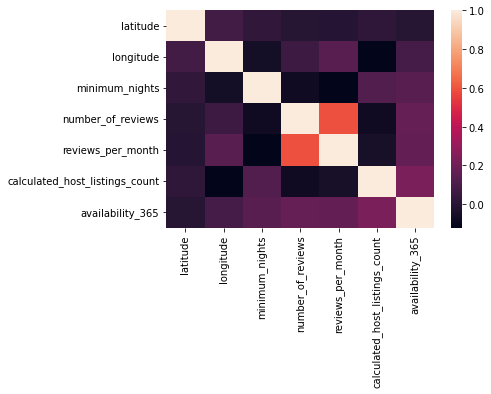

In [67]:
sns.heatmap(df_train.corr())
# for better visualization of correlation values

### Question 3

* Calculate the mutual information score with the (binarized) price for the two categorical variables that we have. Use the training set only.
* Which of these two variables has bigger score?
* Round it to 2 decimal digits using `round(score, 2)`


In [68]:
from sklearn.metrics import mutual_info_score



In [69]:

display(round(mutual_info_score(df_full_train.price,df_full_train.neighbourhood_group),2)) # mutual information score

display(round(mutual_info_score(df_full_train.price,df_full_train.room_type),2)) # mutual information score


0.05

0.14

In [70]:
df_full_train.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
price                               int32
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

### Question 4

* Now let's train a logistic regression
* Remember that we have two categorical variables in the data. Include them using one-hot encoding.
* Fit the model on the training dataset.
   * To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
   * `model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)`
* Calculate the accuracy on the validation dataset and rount it to 2 decimal digits.


In [71]:
df_train.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [72]:
from sklearn.feature_extraction import DictVectorizer


base_features = (categorical + numerical).copy()

base_features.remove('price') # Removing the price 


In [73]:

train_dict= df_train[ base_features ].to_dict(orient='records') # creating a dictionary from the data

train_dict[0]


{'neighbourhood_group': 'Brooklyn',
 'room_type': 'Entire home/apt',
 'latitude': 40.7276,
 'longitude': -73.94495,
 'minimum_nights': 3,
 'number_of_reviews': 29,
 'reviews_per_month': 0.7,
 'calculated_host_listings_count': 13,
 'availability_365': 50}

In [74]:
dv = DictVectorizer(sparse=False) # turn the dictionary into a vector
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [75]:
X_train.shape

(29337, 15)

In [76]:
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

<h1> Logistic Regression </h1>

$$\sigma = \frac{1}{1+exp(-z)}$$

<h2> Training logistic regression with Scikit-Learn </h2>

In [77]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42,max_iter=10000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=10000, random_state=42)

In [78]:
val_dict = df_val[base_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [79]:
model.coef_[0].round(2)

array([ 0.  ,  0.  , -5.94, -3.23, -0.01, -0.16,  0.16,  1.62,  0.02,
       -1.69, -0.  , -0.04,  1.94, -0.85, -1.15])

In [80]:
model.predict_proba(X_val)

array([[0.97141292, 0.02858708],
       [0.40318237, 0.59681763],
       [0.57248768, 0.42751232],
       ...,
       [0.88595557, 0.11404443],
       [0.96557331, 0.03442669],
       [0.47359783, 0.52640217]])

In [81]:
y_pred = model.predict_proba(X_val)[:, 1]

In [82]:
price_predict = (y_pred > 0.5).astype(int)

In [83]:

( y_val == price_predict).mean()



0.7906738930360978


### Question 5

* We have 9 features: 7 numerical features and 2 categorical.
* Let's find the least useful one using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 
* Which of following feature has the smallest difference? 
   * `neighbourhood_group`
   * `room_type` 
   * `number_of_reviews`
   * `reviews_per_month`


In [84]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

base = [
'neighbourhood_group',
'room_type',
'latitude',
'longitude',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365'
]

base1=base.copy()
base1.remove('neighbourhood_group')


base2=base.copy()
base2.remove('room_type')

base3=base.copy()
base3.remove('latitude')


base4=base.copy()
base4.remove('reviews_per_month')



def Feature_model(new_base):
    train_dicts= df_train[new_base].to_dict(orient='records') # creating a dictionary from the data
    
    dv = DictVectorizer(sparse=False) # turn the dictionary into a vector
    X_train = dv.fit_transform(train_dicts) # building a one-hot enconding matrix out of the data
    dv.fit(train_dicts) # SAME as above
    X_train = dv.transform(train_dicts)
    val_dict = df_val[new_base].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=10000)
    model.fit(X_train, y_train)
    model.predict(X_train
    ) # HARD predictions 
    y_pred =model.predict_proba(X_val
    )[:,1]
    #LOGISTIC REGRESSION
    price_predict = (y_pred > 0.5).astype(int)
    original_accuracy= (y_val == price_predict).mean()

    display(original_accuracy)

    return model


display("Removed neighbourhood_group:")
Feature_model(base1)

display("Removed room_type:")
Feature_model(base2)

display("Removed latitude:")
Feature_model(base3)

display("Removed reviews_per_month")
Feature_model(base4)




'Removed neighbourhood_group:'

0.7509970344616014

'Removed room_type:'

0.7288066264444217

'Removed latitude:'

0.7867880151344718

'Removed reviews_per_month'

0.7909806728704366

LogisticRegression(max_iter=10000, random_state=42)

<i> Answer : reviews_per_month </i>


### Question 6

* For this question, we'll see how to use a linear regression model from Scikit-Learn
* We'll need to use the original column `'price'`. Apply the logarithmic transformation to this column.
* Fit the Ridge regression model on the training data.
* This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
* Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.

In [85]:
def prepare_df_lr(df):
    df_copy = df[categorical+numerical]
    df_copy = df_copy.fillna(0)
    return df_copy

In [86]:
df_lr = prepare_df_lr(df)


In [87]:
df_lr.isnull().sum()

neighbourhood_group               0
room_type                         0
latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

<AxesSubplot:xlabel='price', ylabel='Count'>

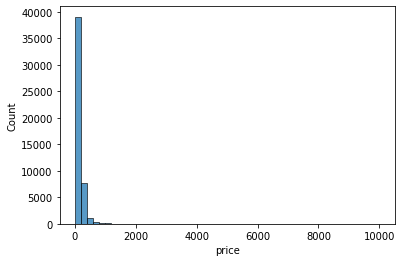

In [88]:
sns.histplot(df_lr.price[df_lr.price < 100000],bins=50)


Giving the shape of the data , is important to take the $log$ distribution 

In [89]:

price_logs = np.log1p(df_lr.price)

display(price_logs)


0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: price, Length: 48895, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

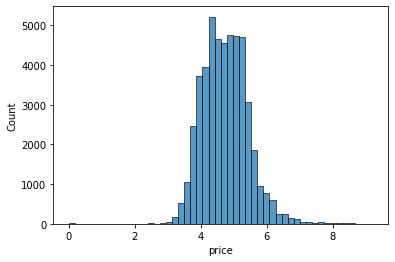

In [90]:

sns.histplot(price_logs,bins=50)


In [91]:
df_lr.price

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df_full_train , df_test =train_test_split(df_lr,test_size=0.2,random_state=42) # Using 20% test Size seed 42
df_train , df_val = train_test_split(df_full_train,test_size=0.25,random_state=42) # From full 
df_train= df_train.reset_index(drop=True) # not necessary for models to work
df_val = df_val.reset_index(drop=True) # not necessary for models to work
df_test = df_test.reset_index(drop=True) # not necessary for models to work
df_full_train = df_full_train.reset_index(drop=True)


# re_defining X variables 

dv = DictVectorizer(sparse=False) # turn the dictionary into a vector
dv.fit(train_dict)
X_train = dv.transform(train_dict)


val_dict = df_val[base_features].to_dict(orient='records')
X_val = dv.transform(val_dict)




# re_defining target variables

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)


#Deleting the price column

del df_train['price']
del df_val['price']
del df_test['price']



In [93]:
y_train



array([4.60517019, 4.06044301, 4.26267988, ..., 5.70378247, 4.18965474,
       4.53259949])



<b> <h1>Linear Regression with  sklearn </h1> </b>

In [94]:
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.metrics import mean_squared_error #IMPORT RMSE
from sklearn.metrics import r2_score




lr = LinearRegression()
lr.fit(X_train, y_train)



LinearRegression()

In [95]:
pred_train_lr= lr.predict(X_train)
print("RMSE:",np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print("R^2:",r2_score(y_train, pred_train_lr))



RMSE: 0.5012521583739057
R^2: 0.4843032604278058


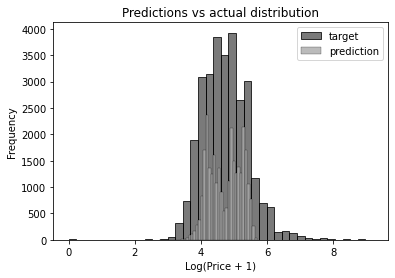

In [96]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(pred_train_lr, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [97]:
# Ridge Regression

for x in [0, 0.01, 0.1, 1, 10]:
    print('For ',x,'alpha')
    rr = Ridge(alpha=x)
    rr.fit(X_train, y_train) 
    pred_train_rr= rr.predict(X_train)
    print(round(np.sqrt(mean_squared_error(y_train,pred_train_rr)),3))
    print(round(np.sqrt(r2_score(y_train, pred_train_rr))),3)


For  0 alpha
0.501
1 3
For  0.01 alpha
0.501
1 3
For  0.1 alpha
0.501
1 3
For  1 alpha
0.501
1 3
For  10 alpha
0.502
1 3


C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.74051e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
